## Load Data from CSVs

In [1]:
import unicodecsv

## Longer version of code (replaced with shorter, equivalent version below)

# enrollments = []
# f = open('enrollments.csv', 'rb')
# reader = unicodecsv.DictReader(f)
# for row in reader:
#     enrollments.append(row)
# f.close()

with open('enrollments.csv', 'rb') as f:
    reader = unicodecsv.DictReader(f)
    enrollments = list(reader)

In [2]:
#####################################
#                 1                 #
#####################################

## Read in the data from daily_engagement.csv and project_submissions.csv 
## and store the results in the below variables.
## Then look at the first row of each table.

def read_csv(filename):
    with open(filename, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)

daily_engagement = read_csv('daily_engagement.csv')
project_submissions = read_csv('project_submissions.csv')

## Fixing Data Types

In [3]:
from datetime import datetime as dt

# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# Clean up the data types in the enrollments table
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
enrollments[0]

{u'account_key': u'448',
 u'cancel_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'days_to_cancel': 65,
 u'is_canceled': True,
 u'is_udacity': True,
 u'join_date': datetime.datetime(2014, 11, 10, 0, 0),
 u'status': u'canceled'}

In [4]:
# Clean up the data types in the engagement table
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    
daily_engagement[0]

{u'acct': u'0',
 u'lessons_completed': 0,
 u'num_courses_visited': 1,
 u'projects_completed': 0,
 u'total_minutes_visited': 11.6793745,
 u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}

In [5]:
# Clean up the data types in the submissions table
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

project_submissions[0]

{u'account_key': u'256',
 u'assigned_rating': u'UNGRADED',
 u'completion_date': datetime.datetime(2015, 1, 16, 0, 0),
 u'creation_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'lesson_key': u'3176718735',
 u'processing_state': u'EVALUATED'}

## Investigating the Data

In [6]:
#####################################
#                 2                 #
#####################################

## Find the total number of rows and the number of unique students (account keys)
## in each table.

enrollment_num_rows = len(enrollments)
enrollment_num_unique_students = len(set([x['account_key'] for x in enrollments]))

engagement_num_rows = len(daily_engagement)
engagement_num_unique_students = len(set([x['acct'] for x in daily_engagement]))

submission_num_rows = len(project_submissions)
submission_num_unique_students = len(set([x['account_key'] for x in project_submissions]))

## Problems in the Data

In [7]:
#####################################
#                 3                 #
#####################################

## Rename the "acct" column in the daily_engagement table to "account_key".

for engagement in daily_engagement:
    engagement['account_key'] = engagement['acct']
    del engagement['acct']

## Missing Engagement Records

In [8]:
#####################################
#                 4                 #
#####################################

## Find any one student enrollments where the student is missing from the daily engagement table.
## Output that enrollment.

daily_engagement_account_keys = set([x['account_key'] for x in daily_engagement])

for enrollment in enrollments:
    if enrollment['account_key'] not in daily_engagement_account_keys:
        print enrollment
        break

{u'status': u'canceled', u'is_udacity': False, u'is_canceled': True, u'join_date': datetime.datetime(2014, 11, 12, 0, 0), u'account_key': u'1219', u'cancel_date': datetime.datetime(2014, 11, 12, 0, 0), u'days_to_cancel': 0}


## Checking for More Problem Records

In [9]:
#####################################
#                 5                 #
#####################################

## Find the number of surprising data points (enrollments missing from
## the engagement table) that remain, if any.

count = 0
for enrollment in enrollments:
    if enrollment['account_key'] not in daily_engagement_account_keys and \
       (enrollment['days_to_cancel'] > 0 or enrollment['days_to_cancel'] is None):
        count += 1
        print enrollment
print count


{u'status': u'canceled', u'is_udacity': True, u'is_canceled': True, u'join_date': datetime.datetime(2015, 1, 10, 0, 0), u'account_key': u'1304', u'cancel_date': datetime.datetime(2015, 3, 10, 0, 0), u'days_to_cancel': 59}
{u'status': u'canceled', u'is_udacity': True, u'is_canceled': True, u'join_date': datetime.datetime(2015, 3, 10, 0, 0), u'account_key': u'1304', u'cancel_date': datetime.datetime(2015, 6, 17, 0, 0), u'days_to_cancel': 99}
{u'status': u'current', u'is_udacity': True, u'is_canceled': False, u'join_date': datetime.datetime(2015, 2, 25, 0, 0), u'account_key': u'1101', u'cancel_date': None, u'days_to_cancel': None}
3


## Tracking Down the Remaining Problems

In [10]:
# Create a set of the account keys for all Udacity test accounts
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
len(udacity_test_accounts)

6

In [11]:
# Given some data with an account_key field, removes any records corresponding to Udacity test accounts
def remove_udacity_accounts(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

In [12]:
# Remove Udacity test accounts from all three tables
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print len(non_udacity_enrollments)
print len(non_udacity_engagement)
print len(non_udacity_submissions)

1622
135656
3634


## Refining the Question

In [13]:
#####################################
#                 6                 #
#####################################

## Create a dictionary named paid_students containing all students who either
## haven't canceled yet or who remained enrolled for more than 7 days. The keys
## should be account keys, and the values should be the date the student enrolled.

paid_students = {}
for enrollment in non_udacity_enrollments:
    if enrollment['days_to_cancel'] > 7 or not enrollment['is_canceled']:
        account_key = enrollment['account_key']
        enrollment_date = enrollment['join_date']
        
        if account_key not in paid_students or \
           enrollment_date > paid_students[account_key]:
            paid_students[account_key] = enrollment_date
        
len(paid_students)

995

## Getting Data from First Week

In [14]:
# Takes a student's join date and the date of a specific engagement record,
# and returns True if that engagement record happened within one week
# of the student joining.
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days >= 0

In [15]:
non_udacity_enrollments[0]

{u'account_key': u'700',
 u'cancel_date': datetime.datetime(2014, 11, 16, 0, 0),
 u'days_to_cancel': 6,
 u'is_canceled': True,
 u'is_udacity': False,
 u'join_date': datetime.datetime(2014, 11, 10, 0, 0),
 u'status': u'canceled'}

In [16]:
#####################################
#                 7                 #
#####################################

## Create a list of rows from the engagement table including only rows where
## the student is one of the paid students you just found, and the date is within
## one week of the student's join date.

paid_engagement_in_first_week = []
for engagement in non_udacity_engagement:
    account_key = engagement['account_key']
    if account_key in paid_students.keys() and \
       within_one_week(paid_students[account_key], engagement['utc_date']):
        paid_engagement_in_first_week.append(engagement)
    
print len(paid_engagement_in_first_week)

6919


## Exploring Student Engagement

In [17]:
from collections import defaultdict

# Create a dictionary of engagement grouped by student.
# The keys are account keys, and the values are lists of engagement records.
engagement_by_account = defaultdict(list)
for engagement_record in paid_engagement_in_first_week:
    account_key = engagement_record['account_key']
    engagement_by_account[account_key].append(engagement_record)

In [18]:
# Create a dictionary with the total minutes each student spent in the classroom during the first week.
# The keys are account keys, and the values are numbers (total minutes)
total_minutes_by_account = {}
for account_key, engagement_for_student in engagement_by_account.items():
    total_minutes = 0
    for engagement_record in engagement_for_student:
        total_minutes += engagement_record['total_minutes_visited']
    total_minutes_by_account[account_key] = total_minutes

In [19]:
import numpy as np

# Summarize the data about minutes spent in the classroom
total_minutes = total_minutes_by_account.values()
print 'Mean:', np.mean(total_minutes)
print 'Standard deviation:', np.std(total_minutes)
print 'Minimum:', np.min(total_minutes)
print 'Maximum:', np.max(total_minutes)

Mean: 306.708326753
Standard deviation: 412.996933409
Minimum: 0.0
Maximum: 3564.7332645


## Debugging Data Analysis Code

In [20]:
#####################################
#                 8                 #
#####################################

## Go through a similar process as before to see if there is a problem.
## Locate at least one surprising piece of data, output it, and take a look at it.

max_time_account_key = max(total_minutes_by_account, key=total_minutes_by_account.get)
engagement_by_account[max_time_account_key]
    

[{'account_key': u'163',
  u'lessons_completed': 4,
  u'num_courses_visited': 4,
  u'projects_completed': 0,
  u'total_minutes_visited': 850.519339666,
  u'utc_date': datetime.datetime(2015, 7, 9, 0, 0)},
 {'account_key': u'163',
  u'lessons_completed': 6,
  u'num_courses_visited': 6,
  u'projects_completed': 0,
  u'total_minutes_visited': 872.633923334,
  u'utc_date': datetime.datetime(2015, 7, 10, 0, 0)},
 {'account_key': u'163',
  u'lessons_completed': 6,
  u'num_courses_visited': 2,
  u'projects_completed': 0,
  u'total_minutes_visited': 777.018903666,
  u'utc_date': datetime.datetime(2015, 7, 11, 0, 0)},
 {'account_key': u'163',
  u'lessons_completed': 2,
  u'num_courses_visited': 1,
  u'projects_completed': 0,
  u'total_minutes_visited': 294.568774,
  u'utc_date': datetime.datetime(2015, 7, 12, 0, 0)},
 {'account_key': u'163',
  u'lessons_completed': 1,
  u'num_courses_visited': 3,
  u'projects_completed': 0,
  u'total_minutes_visited': 471.2139785,
  u'utc_date': datetime.dateti

## Lessons Completed in First Week

In [21]:
#####################################
#                 9                 #
#####################################

## Adapt the code above to find the mean, standard deviation, minimum, and maximum for
## the number of lessons completed by each student during the first week. Try creating
## one or more functions to re-use the code above.

def attribute_sum_per_student(data_dict, attribute):
    attribute_sum_by_account = {}
    for account_key, student in data_dict.items():
        attribute_sum = 0
        for engagement_record in student:
            attribute_sum += engagement_record[attribute]
        attribute_sum_by_account[account_key] = attribute_sum
    return attribute_sum_by_account

def print_stats_for_single_value_dict(data_dict):
    attribute_sum = data_dict.values()
    print 'Mean:', np.mean(attribute_sum)
    print 'Standard deviation:', np.std(attribute_sum)
    print 'Minimum:', np.min(attribute_sum)
    print 'Maximum:', np.max(attribute_sum)
    
print_stats_for_single_value_dict(attribute_sum_per_student(engagement_by_account, 'lessons_completed'))

Mean: 1.63618090452
Standard deviation: 3.00256129983
Minimum: 0
Maximum: 36


## Number of Visits in First Week

In [22]:
######################################
#                 10                 #
######################################

## Find the mean, standard deviation, minimum, and maximum for the number of
## days each student visits the classroom during the first week.

for account, engagements in engagement_by_account.items():
    for engagement in engagements:
        if engagement['num_courses_visited'] > 0:
            engagement['has_visited'] = 1
        else:
            engagement['has_visited'] = 0

print_stats_for_single_value_dict(attribute_sum_per_student(engagement_by_account, 'has_visited'))

Mean: 2.86733668342
Standard deviation: 2.25519800292
Minimum: 0
Maximum: 7


## Splitting out Passing Students

In [23]:
######################################
#                 11                 #
######################################

## Create two lists of engagement data for paid students in the first week.
## The first list should contain data for students who eventually pass the
## subway project, and the second list should contain data for students
## who do not.

subway_project_lesson_keys = ['746169184', '3176718735']
passing_ratings = ['PASSED', 'DISTINCTION']

passing_students = set()
for submission in non_udacity_submissions:
    if submission['assigned_rating'] in passing_ratings and \
       submission['lesson_key'] in subway_project_lesson_keys:
        passing_students.add(submission['account_key'])

passing_engagements = []
non_passing_engagements = []
for account, engagements in engagement_by_account.items():
    if account in passing_students:
        passing_engagements += engagements
    else:
        non_passing_engagements += engagements
    
print len(passing_engagements)
print len(non_passing_engagements)

4527
2392


## Comparing the Two Student Groups

In [24]:
######################################
#                 12                 #
######################################

## Compute some metrics you're interested in and see how they differ for
## students who pass the subway project vs. students who don't. A good
## starting point would be the metrics we looked at earlier (minutes spent
## in the classroom, lessons completed, and days visited).

passing_engagements_by_account = defaultdict(list)
non_passing_engagements_by_account = defaultdict(list)

for account, engagements in engagement_by_account.items():
    if account in passing_students:
        passing_engagements_by_account[account] = engagements
    else:
        non_passing_engagements_by_account[account] = engagements

print_stats_for_single_value_dict(attribute_sum_per_student(passing_engagements_by_account, 'total_minutes_visited'))
print_stats_for_single_value_dict(attribute_sum_per_student(non_passing_engagements_by_account, 'total_minutes_visited'))

Mean: 394.586046484
Standard deviation: 448.499519327
Minimum: 0.0
Maximum: 3564.7332645
Mean: 143.326474267
Standard deviation: 269.538619011
Minimum: 0.0
Maximum: 1768.52274933


## Making Histograms

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


(array([ 272.,   34.,   17.,    9.,    6.,    2.,    1.,    5.,    0.,    2.]),
 array([    0.        ,   176.85227493,   353.70454987,   530.5568248 ,
          707.40909973,   884.26137467,  1061.1136496 ,  1237.96592453,
         1414.81819947,  1591.6704744 ,  1768.52274933]),
 <a list of 10 Patch objects>)

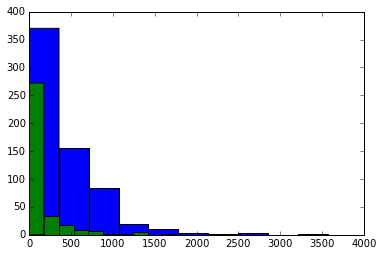

In [25]:
######################################
#                 13                 #
######################################

## Make histograms of the three metrics we looked at earlier for both
## students who passed the subway project and students who didn't. You
## might also want to make histograms of any other metrics you examined.

%pylab inline
import matplotlib.pyplot as plt
plt.hist(attribute_sum_per_student(passing_engagements_by_account, 'total_minutes_visited').values())
plt.hist(attribute_sum_per_student(non_passing_engagements_by_account, 'total_minutes_visited').values())

(array([   0.,    0.,    0.,    0.,    0.,  348.,    0.,    0.,    0.,    0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

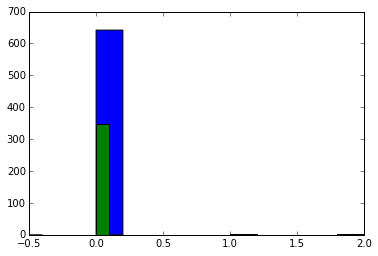

In [26]:
plt.hist(attribute_sum_per_student(passing_engagements_by_account, 'projects_completed').values())
plt.hist(attribute_sum_per_student(non_passing_engagements_by_account, 'projects_completed').values())

(array([ 317.,   17.,    6.,    4.,    1.,    1.,    0.,    1.,    0.,    1.]),
 array([  0. ,   2.7,   5.4,   8.1,  10.8,  13.5,  16.2,  18.9,  21.6,
         24.3,  27. ]),
 <a list of 10 Patch objects>)

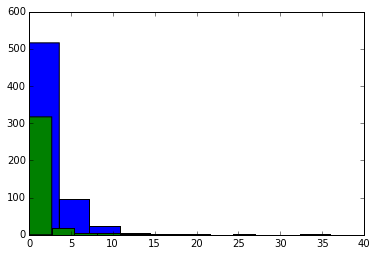

In [27]:
plt.hist(attribute_sum_per_student(passing_engagements_by_account, 'lessons_completed').values())
plt.hist(attribute_sum_per_student(non_passing_engagements_by_account, 'lessons_completed').values())

(array([ 97.,  90.,  56.,   0.,  41.,  15.,   0.,  24.,  17.,   8.]),
 array([ 0. ,  0.7,  1.4,  2.1,  2.8,  3.5,  4.2,  4.9,  5.6,  6.3,  7. ]),
 <a list of 10 Patch objects>)

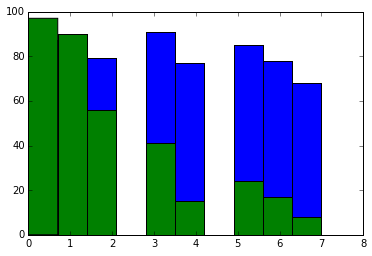

In [28]:
plt.hist(attribute_sum_per_student(passing_engagements_by_account, 'has_visited').values())
plt.hist(attribute_sum_per_student(non_passing_engagements_by_account, 'has_visited').values())

## Improving Plots and Sharing Findings

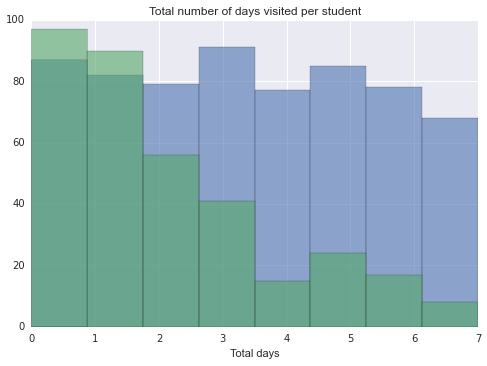

In [29]:
######################################
#                 14                 #
######################################

## Make a more polished version of at least one of your visualizations
## from earlier. Try importing the seaborn library to make the visualization
## look better, adding axis labels and a title, and changing one or more
## arguments to the hist() function.

import seaborn as sns
plt.hist(attribute_sum_per_student(passing_engagements_by_account, 'has_visited').values(), bins=8, alpha=0.6)
plt.hist(attribute_sum_per_student(non_passing_engagements_by_account, 'has_visited').values(), bins=8, alpha=0.6)
plt.title('Total number of days visited per student')
plt.xlabel('Total days')

# attribute_sum_per_student(non_passing_engagements_by_account, 'has_visited').values()